The codes have commented the ones thta applying the simple classifiers, as LR and NB, to the datasets with the pretrained word embeddings.

In [7]:

import pandas as pd
import numpy as np
import re, string
import matplotlib.pyplot as plt
import transformers
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
import seaborn as sns
import torch
import gensim
from gensim.models import Word2Vec


[nltk_data] Downloading package punkt to /home/amber/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/amber/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/amber/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/amber/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
df_train= pd.read_csv('/home/amber/Documents/NLP_Assignments/A2/data/TRAIN/old/labeled_10k.csv', encoding='cp1252')
df_test=pd.read_csv('/home/amber/Documents/NLP_Assignments/A2/data/TEST/labeled_17k.csv', encoding='cp1252')

In [9]:
# WORD-COUNT
df_train['word_count'] = df_train['moment'].apply(lambda x: len(str(x).split()))


##Data Cleaning

In [10]:
# Transfer the string to numeric data
df_train['agency'] = df_train['agency'].map({'yes': 1, 'no': 0})
df_train['social'] = df_train['social'].map({'yes': 1, 'no': 0})

df_test['agency'] = df_test['agency'].map({'yes': 1, 'no': 0})
df_test['social'] = df_test['social'].map({'yes': 1, 'no': 0})

df_train.head()

,hmid,moment,concepts,agency,social,age,country,gender,married,parenthood,reflection,word_count
0,27674,I was happy when my son got 90% marks in his e...,education|family,0,1,29.0,IND,m,married,y,24h,12
1,27685,went to movies with my friends it was fun,entertainment,1,1,29.0,IND,m,single,y,24h,9
2,27691,A hot kiss with my girl friend last night made...,romance,1,1,25.0,IND,m,married,y,24h,12
3,27701,My son woke me up to a fantastic breakfast of ...,family|food,0,1,79,USA,f,widowed,y,24h,17
4,27712,My older daughter keeps patting my younger dau...,family,0,1,30,USA,f,married,y,24h,9


In [11]:
# convert the original data to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower()
    text=text.strip()
    text=re.compile('<.*?>').sub('', text)
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub(r'\[[0-9]*\]',' ',text)
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text)
    text = re.sub(r'\s+',' ',text)
    return text

# Lexicon - based
# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)#LEMMATIZATION
# Initialize the lemmatizer

# #2. STEMMING
# # Initialize the stemmer
# snow = SnowballStemmer('english')
# def stemming(string):
#     a=[snow.stem(i) for i in word_tokenize(string) ]
#     return " ".join(a)

# 3.
wl = WordNetLemmatizer()
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN# Tokenize the sentence
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [12]:
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))
df_train['clean_text'] = df_train['moment'].apply(lambda x: finalpreprocess(x))
df_train.head()

df_test['clean_text'] = df_test['moment'].apply(lambda x: finalpreprocess(x))
df_test.head()

,hmid,moment,reflection,age,country,gender,duration,married,parenthood,concepts,agency,social,clean_text
0,0,I was able to spend the day with my fiance sho...,24h,28,USA,m,all_day_im_still_feeling_it,single,n,shopping|family|romance,1,0,able spend day fiance shopping yesterday
1,1,I was able to play with my cat.,24h,28,USA,m,at_least_one_hour,single,n,animals,1,0,able play cat
2,2,I was able to clean my room and gold my laundry.,24h,28,USA,m,at_least_one_hour,single,n,0,1,0,able clean room gold laundry
3,3,I spend the day at a party on the beach and I ...,24h,24,USA,m,half_a_day,single,n,vacation|party|weather,1,1,spend day party beach happy see friend miss be...
4,4,My cat greeting me when I got home from work -...,24h,24,USA,m,half_a_day,single,n,animals,0,0,cat greet get home work sweet cute loving


TRAIN TEST SPLITTING OF LABELLED DATASET

In [13]:
#SPLITTING THE TRAINING DATASET INTO TRAINING AND VALIDATION

# Input: "reviewText", "rating" and "time"
# Target: "log_votes"
#X_train, X_val, y_train, y_val = train_test_split(df_train["clean_text"], df_train["agency"],test_size=0.2,shuffle=True)

X_train, X_val, y_train, y_val = train_test_split(df_train["clean_text"], df_train["agency"],test_size=0.2,shuffle=True)
X_train_s, X_val_s, y_train_s, y_val_s = train_test_split(df_train["clean_text"], df_train["social"],test_size=0.2,shuffle=True)
X_train_m, X_val_m, y_train_m, y_val_m = train_test_split(df_train["clean_text"],pd.DataFrame({'agency':df_train["agency"],'social':df_train["social"]}),test_size=0.2,shuffle=True)
# print(y_train_s)
#print(len(X_train), len(y_train))


3). Logistic Regression with Word2Vec

Tokenized with Bert

In [14]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True, model_max_length=512)


In [15]:
# Concatenate train data and test data
all_text = np.concatenate([df_train.moment.values, df_test.moment.values])
# Encode our concatenated data
encoded_text = [tokenizer.encode(i, add_special_tokens=True) for i in all_text]
#print(encoded_text)
embed_vocab = {}
for word in tokenizer.vocab.keys():
    embed_vocab[word] = True
print(len(embed_vocab))
# Find the maximum length
max_len = max([len(i) for i in encoded_text])
print('Max length: ', max_len)

30522
Max length:  155


In [64]:
text = df_train['clean_text']
text_words = []
text_vocab = {}
for string in text:
    # Don't include words that can't actually be mapped to a vector using embeddings
    words = string.split()
    filtered_words = []
    for word in words:
        text_vocab[word] = True
        if embed_vocab.get(word) is not None:
            filtered_words.append(word)
    text_words.append(filtered_words)

In [34]:
print(text_words)

[['happy', 'son', 'get', 'mark', 'examination'], ['go', 'movie', 'friend', 'fun'], ['hot', 'kiss', 'girl', 'friend', 'last', 'night', 'make', 'day'], ['son', 'wake', 'fantastic', 'breakfast', 'egg', 'special', 'hamburger', 'patty'], ['old', 'daughter', 'keep', 'pat', 'young', 'daughter', 'head'], ['cook', 'girlfriend', 'wonderful', 'breakfast'], ['mother', 'give', 'surprise', 'visit', 'home'], ['hardly', 'traffic', 'way', 'work', 'morning'], ['come', 'office', 'right', 'time'], ['day', 'get', 'degree', 'industrial', 'engineering'], ['go', 'office', 'hour', 'one', 'professor', 'realize', 'care', 'professor', 'mentor', 'ever'], ['lady', 'member', 'family', 'go', 'lunch', 'seven', 'star', 'hotel', 'n', 'much', 'fun', 'lady', 'go', 'together', 'n', 'gossip'], ['wife', 'come', 'home', 'work', 'share', 'steak', 'dinner', 'together', 'bottle', 'wine'], ['father', 'buy', 'bicycle'], ['go', 'home', 'give', 'ice', 'cream', 'family', 'pack', 'family', 'particularly', 'hand', 'son', 'create', 'mom

In [65]:
def vocab_coverage(compared, base):  #, k):
    hit, miss = 0, 0
    for word in compared:
        if base.get(word) is not None:
            hit += 1
        else:
            miss += 1
            #base[word] = np.random.uniform(-0.25, 0.25, k)
    print("{} words were found".format(hit))
    print("{} words weren't found".format(miss))
    #print("new length of {} word_vectors".format(len(embed_vocab)))

vocab_coverage(text_vocab, embed_vocab)  # , 300)

4544 words were found
1391 words weren't found


In [16]:
def preprocessing_data(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    MAX_LEN = 128

    # For every sentence...
    for i in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text = i ,  # Preprocess sentence
            add_special_tokens=False,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=False      # Return attention mask
            )

        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))

    # # Convert lists to tensors
    # input_ids = torch.tensor(input_ids)
    # attention_masks = torch.tensor(attention_masks)

    return input_ids



In [17]:
#prepare input under agency/sociality/combined class
train_inputs = preprocessing_data(X_train)
val_inputs = preprocessing_data(X_val)

train_inputs_s = preprocessing_data(X_train_s)
val_inputs_s = preprocessing_data(X_val_s)

train_inputs_m = preprocessing_data(X_train_m)
val_inputs_m = preprocessing_data(X_val_m)




In [18]:
test_inputs = preprocessing_data(df_test['clean_text'])

Basic classifiers under Bert tokenizer

In [19]:
import torch
from torch.utils.data import TensorDataset, DataLoader

batch_size = 32
print(type(y_train))

datasets = {
    'train_a': TensorDataset(torch.tensor(train_inputs), torch.tensor(y_train.values)),
    'val_a': TensorDataset(torch.tensor(val_inputs),  torch.tensor(y_val.values)),
    'train_s': TensorDataset(torch.tensor(train_inputs_s),  torch.tensor(y_train_s.values)),
    'val_s': TensorDataset(torch.tensor(val_inputs_s),  torch.tensor(y_val_s.values)),
    'test': TensorDataset(torch.tensor(test_inputs),  torch.tensor(df_test['social'].values)),

}
print(datasets['train_a'])
dataloaders = {
    'train_a': DataLoader(datasets['train_a'], batch_size=batch_size),
    'val_a': DataLoader(datasets['val_a'], batch_size=batch_size),
    'train_s': DataLoader(datasets['train_s'], batch_size=batch_size),
    'val_s': DataLoader(datasets['val_s'], batch_size=batch_size),
    'test': DataLoader(datasets['test'], batch_size=batch_size),
}

<class 'pandas.core.series.Series'>


2. [30 marks] Train an advanced classifier based on deep learning, such as fine-tuning BERT. You can try predicting both labels independently, or in a multi-task manner. Use part of the training data for validation, and keep aside the test data when choosing the best model.


In [20]:

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("running on the GPU")
else:
    device = torch.device("cpu")
    print("running on the CPU")


running on the GPU


In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    """An 1D Convulational Neural Network for Sentence Classification."""
    def __init__(self,
                 pretrained_embedding=None,
                 freeze_embedding=False,
                 vocab_size=None,
                 embed_dim=300,
                 filter_sizes=[3, 4, 5],
                 num_filters=[100, 100, 100],
                 num_classes=2,
                 dropout=0.5):
        """
        The constructor for CNN_NLP class.

        Args:
            pretrained_embedding (torch.Tensor): Pretrained embeddings with
                shape (vocab_size, embed_dim)
            freeze_embedding (bool): Set to False to fine-tune pretraiend
                vectors. Default: False
            vocab_size (int): Need to be specified when not pretrained word
                embeddings are not used.
            embed_dim (int): Dimension of word vectors. Need to be specified
                when pretrained word embeddings are not used. Default: 300
            filter_sizes (List[int]): List of filter sizes. Default: [3, 4, 5]
            num_filters (List[int]): List of number of filters, has the same
                length as `filter_sizes`. Default: [100, 100, 100]
            n_classes (int): Number of classes. Default: 2
            dropout (float): Dropout rate. Default: 0.5
        """

        super(CNN, self).__init__()
        # Embedding layer
        if pretrained_embedding is not None:
            self.vocab_size, self.embed_dim = pretrained_embedding.shape
            self.embedding = nn.Embedding.from_pretrained(pretrained_embedding,
                                                          freeze=freeze_embedding)
        else:
            self.embed_dim = embed_dim
            self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                          embedding_dim=self.embed_dim,
                                          padding_idx=0,
                                          max_norm=5.0)
        # Conv Network
        self.conv1d_list = nn.ModuleList([
            nn.Conv1d(in_channels=self.embed_dim,
                      out_channels=num_filters[i],
                      kernel_size=filter_sizes[i])
            for i in range(len(filter_sizes))
        ])
        # Fully-connected layer and Dropout
        self.fc = nn.Linear(np.sum(num_filters), num_classes)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input_ids):
        """Perform a forward pass through the network.

        Args:
            input_ids (torch.Tensor): A tensor of token ids with shape
                (batch_size, max_sent_length)

        Returns:
            logits (torch.Tensor): Output logits with shape (batch_size,
                n_classes)
        """

        # Get embeddings from `input_ids`. Output shape: (b, max_len, embed_dim)
        x_embed = self.embedding(input_ids).float()

        # Permute `x_embed` to match input shape requirement of `nn.Conv1d`.
        # Output shape: (b, embed_dim, max_len)
        x_reshaped = x_embed.permute(0, 2, 1)

        # Apply CNN and ReLU. Output shape: (b, num_filters[i], L_out)
        x_conv_list = [F.relu(conv1d(x_reshaped)) for conv1d in self.conv1d_list]

        # Max pooling. Output shape: (b, num_filters[i], 1)
        x_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2])
            for x_conv in x_conv_list]

        # Concatenate x_pool_list to feed the fully connected layer.
        # Output shape: (b, sum(num_filters))
        x_fc = torch.cat([x_pool.squeeze(dim=2) for x_pool in x_pool_list],
                         dim=1)

        # Compute logits. Output shape: (b, n_classes)
        logits = self.fc(self.dropout(x_fc))

        return logits


In [49]:
import torch.optim as optim
from transformers import AdamW
def initilize_model(pretrained_embedding=None,
                    freeze_embedding=False,
                    vocab_size=None,
                    embed_dim=300,
                    filter_sizes=[3, 4, 5],
                    num_filters=[100, 100, 100],
                    num_classes=2,
                    dropout=0.5,
                    learning_rate=5e-5):
    """Instantiate a CNN model and an optimizer."""

    assert (len(filter_sizes) == len(num_filters)), "filter_sizes and \
    num_filters need to be of the same length."

    # Instantiate CNN model
    cnn_model = CNN(pretrained_embedding=pretrained_embedding,
                        freeze_embedding=freeze_embedding,
                        vocab_size=vocab_size,
                        embed_dim=embed_dim,
                        filter_sizes=filter_sizes,
                        num_filters=num_filters,
                        num_classes=2,
                        dropout=0.1)

    # Send model to `device` (GPU/CPU)
    cnn_model.to(device)
    optimizer = AdamW(cnn_model.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )
    # Instantiate Adadelta optimizer
    # optimizer = optim.Adadelta(cnn_model.parameters(),
    #                            lr=learning_rate,
    #                            rho=0.95)

    return cnn_model, optimizer


In [23]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility."""

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, optimizer, train_dataloader, val_dataloader=None, epochs=10):
    """Train the CNN model."""

    # Tracking best validation accuracy
    best_accuracy = 0

    # Start training loop
    print("Start training...\n")
    print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
    print("-"*60)

    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================

        t0_epoch = time.time()
        total_loss = 0

        model.train()

        for step, batch in enumerate(train_dataloader):
            # Load batch to GPU
            b_input_ids, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Update parameters
            optimizer.step()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        # =======================================
        #               Evaluation
        # =======================================
        if val_dataloader is not None:
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Track the best accuracy
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy

            time_elapsed = time.time() - t0_epoch
            print(f"{epoch_i + 1:^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")

    print("\n")
    print(f"Training complete! Best accuracy: {best_accuracy:.2f}%.")

def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's
    performance on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled
    # during the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy


In [53]:
# CNN training
set_seed(42)
cnn, optimizer = initilize_model(vocab_size=len(embed_vocab),
                                      embed_dim=300,
                                      learning_rate=0.001,
                                      dropout=0.1)
train(cnn, optimizer, dataloaders['train_a'], dataloaders['val_a'], epochs=20)


Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   0.589179   |  0.549971  |   73.91   |   1.70   
   2    |   0.525548   |  0.523143  |   74.29   |   1.64   
   3    |   0.487311   |  0.499404  |   75.57   |   1.62   
   4    |   0.448958   |  0.478047  |   77.56   |   1.66   
   5    |   0.411958   |  0.461491  |   78.60   |   1.61   
   6    |   0.375755   |  0.449537  |   79.17   |   1.74   
   7    |   0.344099   |  0.441459  |   79.55   |   1.64   
   8    |   0.314299   |  0.435575  |   79.64   |   1.62   
   9    |   0.288283   |  0.431601  |   79.69   |   1.64   
  10    |   0.262582   |  0.429464  |   80.07   |   1.70   
  11    |   0.238323   |  0.428191  |   79.97   |   1.73   
  12    |   0.217126   |  0.427898  |   79.88   |   1.69   
  13    |   0.196641   |  0.428187  |   79.88   |   1.68   
  14    |   0.178781   |  0.429239  |   79.92   |   1.77   
  15    |   0.160285

In [44]:
# torch.cuda.memory_stats()

In [41]:
import torch.nn.functional as F

def predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []


    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids)
        all_logits.append(logits)

    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [42]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')

    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')

    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [48]:
torch.cuda.empty_cache()

AUC: 0.8391
Accuracy: 80.87%


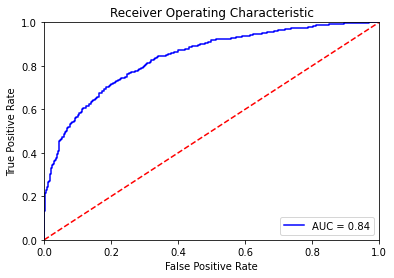

              precision    recall  f1-score   support

           0       0.50      0.68      0.57       399
           1       0.92      0.84      0.88      1713

    accuracy                           0.81      2112
   macro avg       0.71      0.76      0.73      2112
weighted avg       0.84      0.81      0.82      2112



In [54]:
probs_val = predict(cnn, dataloaders['val_a'])

# Evaluate the Bert classifier
evaluate_roc(probs_val, y_val)
# Get predictions from the probabilities
threshold = 0.5
preds_val = np.where(probs_val[:, 1] > threshold, 1, 0)

print(classification_report(preds_val, y_val ))

AUC: 0.7998
Accuracy: 77.08%


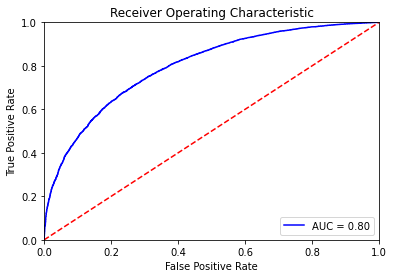

              precision    recall  f1-score   support

           0       0.45      0.66      0.54      3466
           1       0.90      0.80      0.85     13749

    accuracy                           0.77     17215
   macro avg       0.68      0.73      0.69     17215
weighted avg       0.81      0.77      0.79     17215



In [55]:
# Compute predicted probabilities on the test set
probs_test = predict(cnn, dataloaders['test'])

# Get predictions from the probabilities
threshold = 0.5
preds_test = np.where(probs_test[:, 1] > threshold, 1, 0)

# Number of tweets predicted non-negative
#print("Number of tweets predicted non-negative: ", preds_test.sum())

# Evaluate the Bert classifier
evaluate_roc(probs_test, df_test['agency'] )
print(classification_report(preds_test, df_test['agency'] ))

In [56]:
# For sociality
# CNN-rand: Word vectors are randomly initialized.
set_seed(42)
cnn_s, optimizer = initilize_model(vocab_size=len(embed_vocab),
                                      embed_dim=300,
                                      learning_rate=0.001,
                                      dropout=0.1)
train(cnn_s, optimizer, dataloaders['train_s'], dataloaders['val_s'], epochs=20)


Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   0.650148   |  0.603354  |   68.47   |   1.77   
   2    |   0.554212   |  0.517061  |   77.60   |   1.62   
   3    |   0.460730   |  0.442157  |   81.63   |   1.65   
   4    |   0.378536   |  0.386134  |   84.33   |   1.64   
   5    |   0.314341   |  0.349456  |   85.46   |   1.77   
   6    |   0.267978   |  0.326702  |   86.03   |   1.71   
   7    |   0.231593   |  0.312941  |   86.98   |   1.74   
   8    |   0.203330   |  0.304567  |   87.36   |   1.63   
   9    |   0.178173   |  0.299769  |   87.55   |   1.56   
  10    |   0.158158   |  0.297473  |   87.69   |   1.59   
  11    |   0.140293   |  0.296973  |   87.74   |   1.56   
  12    |   0.123757   |  0.297742  |   87.93   |   1.59   
  13    |   0.110174   |  0.299466  |   87.69   |   1.59   
  14    |   0.096987   |  0.301754  |   87.88   |   1.57   
  15    |   0.085626

AUC: 0.9427
Accuracy: 88.21%


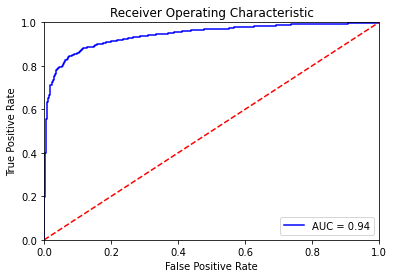

              precision    recall  f1-score   support

           0       0.89      0.87      0.88      1012
           1       0.88      0.90      0.89      1100

    accuracy                           0.88      2112
   macro avg       0.88      0.88      0.88      2112
weighted avg       0.88      0.88      0.88      2112



In [57]:
probs_val_s = predict(cnn_s,  dataloaders['val_s'])

# Evaluate the Bert classifier
evaluate_roc(probs_val_s, y_val_s)
# Get predictions from the probabilities
threshold = 0.5
preds_val_s = np.where(probs_val_s[:, 1] > threshold, 1, 0)

print(classification_report(preds_val_s, y_val_s ))


AUC: 0.9385
Accuracy: 87.16%


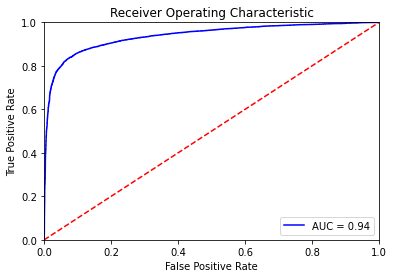

Number of tweets predicted non-negative:  9754
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      7461
           1       0.88      0.89      0.89      9754

    accuracy                           0.87     17215
   macro avg       0.87      0.87      0.87     17215
weighted avg       0.87      0.87      0.87     17215



In [58]:
# Compute predicted probabilities on the test set
probs_test_s = predict(cnn_s, dataloaders['test'])
# Evaluate the Bert classifier
evaluate_roc(probs_test_s, df_test['social'] )
# Get predictions from the probabilities
preds_test_s = np.where(probs_test_s[:, 1] > threshold, 1, 0)

# Number of tweets predicted non-negative
print("Number of tweets predicted non-negative: ", preds_test_s.sum())


print(classification_report(preds_test_s, df_test['social'] ))

In [59]:
output = df_test[preds_test==1]
list(output.sample(20).moment)

['My friend finished radiation treatments!',
 'Completed a preliminary step for a home repair project',
 'I enjoyed reading in bed later than usual since I am on vacation',
 'I got a promotion at work, which included more responsibility and pay.',
 'When I went out with my friends and we had a lot of funny moments talking about stupid things.',
 '3 hours before my boyfriend call to me and he is preposed to me .im so shocked and feel very happy.im not expert that.this moment is very important to my life.im so happy.',
 'My twins turned 1.5 years old, and as a first time mother, it means so much to see them grow.',
 'I WENT TO FRIENDS PARTY.',
 'i am join the job very happy in my all family.one month salary given by family in holders happy',
 'I found 5 dollars on the ground',
 "My life isn't that exciting to actually have 3 significant things happen to me in 24 hours.",
 'My husband I finalized plans for a trip to the mountains this weekend.',
 'I quit smoking.',
 'I played a "cat and m

In [60]:
output_s = df_test[preds_test_s==1]
list(output_s.sample(20).moment)

['I sat on a beach in Barcelona with my friends at night and watched fireworks in the distance.',
 'When i woke up and saw that a friend of mine paid me some money he owed me.',
 'MY HUSBAND TOLD ME WHAT HE WANTED TO DO FOR ME FOR MY BIRTHDAY.',
 'Getting to sleep next to my boyfriend last night  made me happy.',
 'A student brought me coffee.',
 'I was watching a video on a phone with my extended family and it made me feel valuable as a family member.',
 'Having the fox come towards me when I called to it.',
 'My father got a lottery prize.',
 'My daughter was very week in math but yesterday she got very good mark and make me proud',
 'yesterday met my grndma',
 'The department secretary gave me a new desk for my shared office and all of the drawers work.',
 'the moment i share my timings with my family members and with my kids',
 'I was happy to have a day off from work where I was able to enjoy a day of shopping and eating out with my spouse on Cape Cod.',
 'Me and my girlfriend mov